# Exercise: Cache Bandwidths

In this exercise you will benchmark a **Schoenauer triad** kernel (i.e. `a[i] = b[i] + c[i] * d[i]`) and see how the observed performance is effected by the memory hierarchy, i.e. different cache levels.

**Hint:** On most systems, you can programmatically query the cache sizes via

```julia
using CpuId
cachesize()
```

(It doesn't work on Apple silicon.)

## Tasks

1) Inspect the code below and implement the missing piece (look for the single TODO annotation).

In [ ]:
y[i] = a[i] * x[i] + y[i]

In [1]:
using Plots
using BenchmarkTools
using CpuId
using Statistics

"""
SDAXPY: `y[i] = a[i] * x[i] + y[i]` (Schoenauer triad without write-allocate.)

The arguments `y, a, x` are vectors of length `n`.
"""
function sdaxpy!(y, a, x, n)
    @inbounds for i in 1:n
         y[i] = a[i] * x[i] + y[i]
    end
end

"""
    vector_lengths(lo::Integer, hi::Integer, ni::Integer; factor::Integer=32)

Given some lower (`lo`) and upper (`hi`) bound in bytes, returns ≤ ni distinct integers
that are
- more or less evenly separated between lo and hi
- multiples of `factor`

These integers are to be used as vector lengths for the inputs to `sdaxpy!` and determine
the number of loop iterations therein.
"""
function vector_lengths(lo::Integer, hi::Integer, ni::Integer; factor::Integer=32)
    r_log = range(log10(lo / 32), log10(hi / 32), ni)
    r = round.(Integer, exp10.(r_log))
    r_factor = r .& (~(factor-1)) # biggest multiple of factor <= number
    return unique(r_factor)
end

"""
Perform a benchmark of the SDAXPY kernel (Schoenauer triad without write-allocate).
See `vector_lengths` for explanations of the input arguments.
"""
function bench(lo, hi, n; nbench, kwargs...)
    ts = Float64[]
    Ns = vector_lengths(lo, hi, n; kwargs...)
    for n in Ns
        y = fill(1.2, n)
        a = fill(0.8, n)
        x = fill(3.14, n)
        t = @belapsed for i in 1:$nbench
            sdaxpy!($y, $a, $x, $n)
        end samples = 30
        push!(ts, t / nbench)
        println("finished n = $n, time: ", ts[end], " sec bandwidth: ", 32.0e-9 * n / ts[end], " GB/s")
        flush(stdout)
    end
    return Ns, ts
end

function plot_results(Ns, ts)
    p = plot(Ns, Ns ./ ts .* 32.0e-9, marker=:circle, label="sdaxpy!", frame=:box, ms=2, xscale=:log10)
    ylabel!(p, "bandwidth [GB/s]")
    xlabel!(p, "vector size n")
    L1, L2, L3 = cachesize()
    mem = 4 * sizeof(Float64) # four arrays a, b, c, and d in `sdaxpy!`
    nL1 = L1 / mem
    nL2 = L2 / mem
    nL3 = L3 / mem
    vline!(p, [nL1], color=:orange, lw=2, label="L1 = $(floor(Int, nL1)) ($(L1/1024) KiB)")
    vline!(p, [nL2], color=:red, lw=2, label="L2 = $(floor(Int, nL2)) ($(L2/1024) KiB)")
    vline!(p, [nL3], color=:purple, lw=2, label="L3 = $(floor(Int, nL3)) ($(L3/1024) KiB)")
    return p
end

"""
Will perform the benchmark and save a plot of the results as png/svg files.
"""
function main()
    L1, L2, L3 = cachesize()
    Ns1, ts1 = bench(1024, L1, 12; nbench=2^24, factor=32)
    Ns2, ts2 = bench(round(Integer, L1 * 1.5), L2, 10; nbench=2^14, factor=64)
    Ns3, ts3 = bench(round(Integer, L2 * 1.5), L3, 10; nbench=2^10, factor=128)
    Ns4, ts4 = bench(round(Integer, L3 * 1.5), L3 * 32, 8; nbench=2^4, factor=64)
    p = plot_results(vcat(Ns1, Ns2, Ns3, Ns4), vcat(ts1, ts2, ts3, ts4))
    # savefig(p, "sdaxpy_contiguous.svg")
    println("L1 bandwidth:\t", round(median(32.0e-9 .* Ns1 ./ ts1); digits=2), " GB/s")
    println("L2 bandwidth:\t", round(median(32.0e-9 .* Ns2 ./ ts2); digits=2), " GB/s")
    println("L3 bandwidth:\t", round(median(32.0e-9 .* Ns3 ./ ts3); digits=2), " GB/s")
    println("Memory bandwidth:\t", round(median(32.0e-9 .* Ns4 ./ ts4); digits=2), " GB/s")
    return p
end

main

2) Run the benchmark by calling the `main()` function. (Note that this can take up to ~7 minutes.)

finished n = 32, time: 3.852476716041565e-9 sec bandwidth: 265.8030341198698 GB/s


finished n = 64, time: 6.944381594657898e-9 sec bandwidth: 294.9146690866562 GB/s


finished n = 96, time: 1.0141836225986481e-8 sec bandwidth: 302.90372784058553 GB/s


finished n = 128, time: 1.3313826143741607e-8 sec bandwidth: 307.65010416824435 GB/s


finished n = 192, time: 1.987634605169296e-8 sec bandwidth: 309.1111406503555 GB/s


finished n = 288, time: 2.9458089172840117e-8 sec bandwidth: 312.8512493097144 GB/s


finished n = 384, time: 3.89363961815834e-8 sec bandwidth: 315.59161106471703 GB/s


finished n = 544, time: 5.786139887571335e-8 sec bandwidth: 300.85688106836983 GB/s


finished n = 736, time: 7.586211091279984e-8 sec bandwidth: 310.45801015307876 GB/s


finished n = 1024, time: 1.0596575677394867e-7 sec bandwidth: 309.23197264473185 GB/s


finished n = 1536, time: 2.774815673828125e-7 sec bandwidth: 177.13609038466362 GB/s


finished n = 1792, time: 3.1593231201171877e-7 sec bandwidth: 181.50723373262613 GB/s


finished n = 2176, time: 3.7082421875e-7 sec bandwidth: 187.77630068154764 GB/s


finished n = 2624, time: 4.7333746337890625e-7 sec bandwidth: 177.39563524213102 GB/s


finished n = 3200, time: 5.560809936523437e-7 sec bandwidth: 184.14583697140253 GB/s


finished n = 3840, time: 7.05736572265625e-7 sec bandwidth: 174.11595888465658 GB/s


finished n = 4672, time: 8.25828369140625e-7 sec bandwidth: 181.03519518901624 GB/s


finished n = 5632, time: 1.1872246704101562e-6 sec bandwidth: 151.80277540706527 GB/s


finished n = 6784, time: 1.4435242309570312e-6 sec bandwidth: 150.38749980391702 GB/s


finished n = 8192, time: 1.6616905517578125e-6 sec bandwidth: 157.7574114041222 GB/s


finished n = 12288, time: 3.8771103515625e-6 sec bandwidth: 101.41986282168408 GB/s


finished n = 19072, time: 6.790681640625e-6 sec bandwidth: 89.87374645114845 GB/s


finished n = 29696, time: 1.12299140625e-5 sec bandwidth: 84.61970365144991 GB/s


finished n = 46208, time: 1.6876759765625e-5 sec bandwidth: 87.61492256420946 GB/s


finished n = 71936, time: 2.755319140625e-5 sec bandwidth: 83.54574851455645 GB/s


finished n = 111872, time: 4.228041796875e-5 sec bandwidth: 84.67049693420611 GB/s


finished n = 174080, time: 6.78787578125e-5 sec bandwidth: 82.06632206481203 GB/s


finished n = 270720, time: 0.000104761591796875 sec bandwidth: 82.69290158168842 GB/s


finished n = 421248, time: 0.0001663003125 sec bandwidth: 81.0577911571874 GB/s


finished n = 655360, time: 0.0003229091123046875 sec bandwidth: 64.94558128236373 GB/s


finished n = 983040, time: 0.000675590625 sec bandwidth: 46.56263547174001 GB/s


finished n = 1522048, time: 0.0016790113125 sec bandwidth: 29.008462085629933 GB/s


finished n = 2356672, time: 0.00331331625 sec bandwidth: 22.76073224220598 GB/s


finished n = 3648896, time: 0.005868808375 sec bandwidth: 19.89580585002488 GB/s


finished n = 5649792, time: 0.0096571985 sec bandwidth: 18.721096392499337 GB/s


finished n = 8747776, time: 0.01410066675 sec bandwidth: 19.85216989827804 GB/s


finished n = 13544512, time: 0.022249946375 sec bandwidth: 19.479794543999212 GB/s


finished n = 20971520, time: 0.03913185925 sec bandwidth: 17.149418730979413 GB/s


L1 bandwidth:	308.38 GB/s
L2 bandwidth:	177.27 GB/s
L3 bandwidth:	84.08 GB/s
Memory bandwidth:	19.87 GB/s
341.548396 seconds (1.12 M allocations: 1.398 GiB, 4.66% gc time, 0.41% compilation time: 3% of which was recompilation)


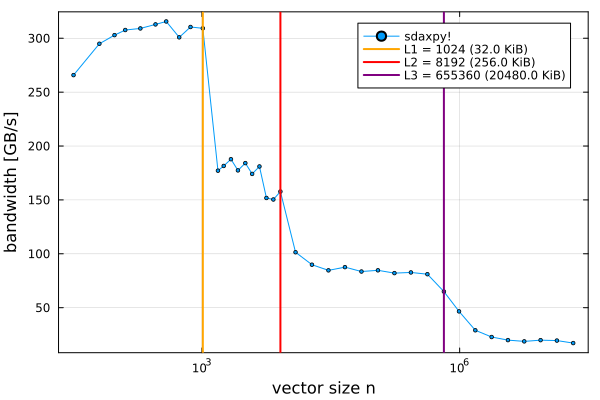

In [2]:
@time main()

* **Questions**
  * Do you understand the trend of the resulting plot?
  * Which bandwidth estimates (in GB/s) do you obtain for L1, L2, L3, and main memory? (Check the textual output of the benchmark.) Fill out the table below.
  
HPC cluster name: Noctua 2, CPU: AMD EPYC 7763:

|  measurements   |  bandwidth [GB/s] |
|:---------------:|:-----------------:|
|  L1D cache      |  TODO              |
|  L2  cache      |  TODO              |
|  L3  cache      |  TODO              |
|  main memory    |  TODO               |


Let's now investigate the performance impact of **strided data access** in comparison to the contiguous data access (as benchmarked above).

3) Copy the entire code from above in the cell below and modify the `sdaxpy!` function such that it only performs the SDAXPY computation to every other vector element (i.e. instead of `1:n` you iterate over `1:2:n`). This corresponds to a stride size of 2.

4) Since we now only perform half as many operations and thus only half of the data transfer, we need to account for this change in all bandwidth computations. Specifically, check all lines that contain `32.0e-09` and insert an extra factor of 0.5.

In [ ]:
# ...

5) Run the benchmark for the strided SDAXPY. How do the results compare to the contiguous case? What's the reason?

In [ ]:
@time main()